# Two dimensional FDTD code for plasmonics

In [195]:
"""2D FDTD with YEE-Algorithmus: leapfrog and staggered grid according to 
    Taflove's book
    - in vacuum with Debye material
    - BC: PEC and PML
    - TE-mode

Richard Ciesielski
"""
%load_ext autoreload
%autoreload 2

from __future__ import division     # 1/2 = .5
from copy import deepcopy
import numpy
import pylab
%matplotlib inline

# Simulation libraries:
from yee_lib_0_4 import *
from yee_excitations_0_4 import *
from yee_objects_0_4 import *
from yee_plot_0_4 import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up the simulation

In [196]:
# create a mesh:
lengthx = 10.
lengthy = 10.
Nx = 88                            # number of nodes for the E-field
dx = lengthx / (Nx - 1)
Ny =  int(lengthy / dx + 1)
lengthy = (Ny - 1) * dx             # adjust the length

# produce a staggered grid with NxN nodes:
grid = staggered_grid_2D(lengthx, lengthy, Nx, Ny, Eps=1)

# add PMLs:
grid.addPML(1.5, "right", 11., "full")
grid.addPML(1.5, "left", 11., "full")
grid.addPML(1.5, "up", 11.)
grid.addPML(1.5, "down", 11.)

grid.addSFTF_contour(3,6,3,6)

In [197]:
# add scatterer:
#wp = 5
#wj = 1
#gamma = 1
#addPlasmonicCircle(grid, 
#    x=10, y=lengthy / 2., R=1., wj=wj, wp=wp, gamma=gamma,  sigma=20)


#addDielectricCircle(grid, 
#    x=10, y=lengthy / 2., R=3., n = 1.5)


# add excitation:
excitations = []
excitations.append(PW_pulse_x_TFSF_Exc(A=1., t0=0., x0=0., dt=1., w0 = 2 * pi * grid.c0 / 0.5))
#excitations.append(LineDipole2DHz_Exc(x=4, y=5, H=1, T=5))
#excitations.append(LineDipole2DHz_Exc(x=6, y=5, H=1, T=4.5))


dt = grid.dt

# for later calculations:
dummy_grid = deepcopy(grid)

In [198]:
grid.ij_SFTF
#grid.mesh_x.shape
8

8


## Executing the simulation

number of nodes : 88 x 88 = 7744 	 time step : 0.0804597701149 	 cycles : 248
simulation time left:  20
simulation time left:  19.0344827586
simulation time left:  18.0689655172
simulation time left:  17.1034482759
simulation time left:  16.1379310345
simulation time left:  15.1724137931
simulation time left:  14.2068965517
simulation time left:  13.2413793103
simulation time left:  12.275862069
simulation time left:  11.3103448276
simulation time left:  10.3448275862
simulation time left:  9.37931034483
simulation time left:  8.41379310345
simulation time left:  7.44827586207
simulation time left:  6.48275862069
simulation time left:  5.51724137931
simulation time left:  4.55172413793
simulation time left:  3.58620689655
simulation time left:  2.62068965517
simulation time left:  1.65517241379
simulation time left:  0.689655172414


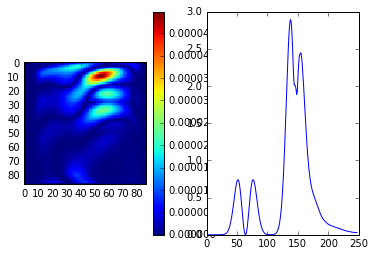

In [199]:
grid.updateConstants()              # absolutely necessary
t, t_end = -5, 15                    # duration of the simulation
i = 0
cycles = int((t_end - t) / dt)      # total number of cycles

print "number of nodes :",Nx, "x", Ny,"=", Nx*Ny, \
        "\t time step :",dt,  "\t cycles :", cycles

# observation of numerical divergences in Ex,Ey,Hz:
bookkeeping = numpy.zeros((2,cycles))
Ex_w = numpy.zeros(grid.Ex.shape, dtype=complex)
Ey_w = numpy.zeros(grid.Ey.shape, dtype=complex)
Hz_w = numpy.zeros(grid.Hz.shape, dtype=complex)

for i in range(cycles):             # main loop
    grid.oEx, grid.oEy, grid.oJx, grid.oJy, \
        grid.Ex, grid.Ey, grid.Jx, grid.Jy, grid.Hz = \
            CalculationStep(grid, dummy_grid, t, excitations)
    
    # print progress:
    if cycles > 20:
        if i % int(cycles / 20) == 0: print "simulation time left: ", t_end - t
    
    # calculate the actual absolute value of the Poynting vector:
    S = numpy.sqrt((grid.Ey* grid.Hz[:, :-1])**2 + 
                                 (grid.Ex[:-1, :-1]  * grid.Hz[:, :-1])**2)
    
    # keep track of the convergence
    bookkeeping[0,i] = numpy.sum(S)
    bookkeeping[1,i] = S[int(Ny/2), int(Nx/2)]
    
    # calculate the Fourier transform
    #Ex_w+= numpy.exp(1j * t * w_probe) * grid.Ex
    #Ey_w+= numpy.exp(1j * t * w_probe) * grid.Ey
    #Hz_w+= numpy.exp(1j * t * w_probe) * grid.Hz

    t = t + dt
    i = i + 1
pylab.subplot(121)
pylab.imshow(S,interpolation='nearest');pylab.colorbar()
pylab.subplot(122)
pylab.plot(bookkeeping[0,:])

## Postprocessing and Plotting

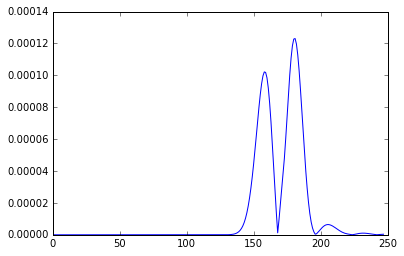

In [193]:
pylab.plot(bookkeeping[1,:])

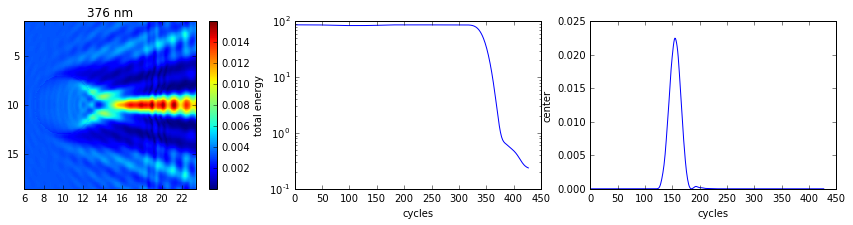

In [51]:
S_w = numpy.sqrt((Ey_w * Hz_w[:, :-1])**2 + 
                                 (Ex_w[:-1, :-1]  * Hz_w[:, :-1])**2)
pylab.figure(figsize=(15,3))
pylab.subplot(131)
#pylab.imshow(abs(S_w))
plot_matrix(abs(S_w), grid, 0, xlim=(6,50))
pylab.colorbar()
pylab.title('%d nm' % (2*pi*3e2 / w_probe))
pylab.subplot(132)
pylab.semilogy(bookkeeping[0])
pylab.xlabel('cycles')
pylab.ylabel('total energy')
pylab.subplot(133)
pylab.plot(bookkeeping[1])
pylab.xlabel('cycles')
pylab.ylabel('center')

In [61]:
cycles

4

In [72]:
(2*pi*3e-1/w_probe)

1.2566370614359172

In [5]:
xlim[0]=2


In [6]:
xlim.to_list

AttributeError: 'list' object has no attribute 'to_list'

In [59]:
i = numpy.linspace(0,10,10)
j = numpy.linspace(3,4,10)
#pylab.plot(i,j,'o')

ij = numpy.array([i,j])

for k,l in zip(i,j):
    print(k+l)

3.0
4.22222222222
5.44444444444
6.66666666667
7.88888888889
9.11111111111
10.3333333333
11.5555555556
12.7777777778
14.0


In [63]:
a=numpy.zeros((10,2))
a[:,0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [65]:
numpy.arange(5,2)

array([], dtype=int32)

In [76]:
a=numpy.array([[i,2] for i in numpy.arange(1,5)])

In [83]:
numpy.concatenate([a,a])

array([[1, 2],
       [2, 2],
       [3, 2],
       [4, 2],
       [1, 2],
       [2, 2],
       [3, 2],
       [4, 2]])